**Take-Home Coding Challenge: Mobile Home Park Identification Model**

**Objective:**
Develop a machine learning model to identify mobile home parks using geospatial data and image classification techniques.

**Requirements:**
Utilize Python and TensorFlow or PyTorch to train a convolutional neural network (CNN) model on satellite imagery data [here](https://drive.google.com/drive/folders/1-0eLvgMHVnCuoZ7FymJnPDUqV1tnNzZP?usp=drive_link). Preprocess the data, including resizing and normalization. Evaluate the model's performance using appropriate metrics and provide insights into its accuracy and efficiency.

**Deliverables:**
Provide the git repo with the Jupyter notebook containing the code for data preprocessing, model training, and evaluation. Include notes that explain the approach, model architecture, and instructions for running the code. Additionally, provide a brief note summarizing the model's performance and suggestions for improvement.

**Evaluation Criteria:**
Candidates will be evaluated based on the effectiveness of the model in identifying mobile home parks, code quality, documentation clarity, and insights provided in the report



---

In [7]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
import numpy as np

## **Loading  and preparing the dataset**

In [8]:
# Import the drive module to interact with Google Drive
from google.colab import drive

# allowing access of files stored in Google Drive from the Colab notebook
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Choosing image size and batch size are very important considerations in training a CNN model.<br>
For computational efficiency, memory constraints and in order to capture sufficient features for classification, lets go for 128 * 128.<br>


Now for the batch size, we will go for 32 as it is commonly used in practice and it also works for a wide range of problems as it strikes a balance between computational efficiency and memory usage.


In [81]:
# setting the height and weight parameter of the i/p image
img_height, img_width = 128, 128 # other common size shapes are 224 * 224 vs 64* 64

# setting the batch size
batch_size = 32

Now, let us preprocess the image befire feeding it into the model

In [82]:
# function for noise removal and normalization
def preprocess_image(img):
  # img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), not using this

  # using Gaussian blur to remove noise
  img_blur = cv2.GaussianBlur(img, (5, 5), 0)

  # normalizing the i/p image by dividing byy 255
  img_norm = img_blur / 255.0

    #img_rgb = cv2.cvtColor(img_norm, cv2.COLOR_GRAY2RGB), not using this

  return img_norm

In [83]:
# function to call the previous noise removal function
def preprocess_input(img):
    img = preprocess_image(img)
    return img

In [86]:
# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,

    # Randomly rotate image within a range of 40 degrees
    rotation_range=40,

    # Randomly shift images horizontally by up to 20% of the width
    width_shift_range=0.2,

    # Randomly shift images vertically by up to 20% of the height
    height_shift_range=0.2,

     # random shearing transformations to the ip mages
    shear_range=0.2,

    # random zooming transformations to the ip images
    zoom_range=0.2,

    # flip images horizontally
    horizontal_flip=True,

    fill_mode='nearest',

    # 20% of the data for validation/testing
    validation_split=0.2
)

So, for the data preprocessing we have normalized the data, removed noise, used data augmentation to improve the model's generalization ability and reduce overfitting and split the training and testing data.<br>
Now, let us load the actual training and testing data

In [87]:
# Define the paths to the folders
# change the path to our dataset here
data_dir = "/content/drive/MyDrive/Colab Notebooks/Data"


In [88]:
# Load training data
train_generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

# load validation/testing data
validation_generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [89]:
# Verify the counts
print(f"Found {train_generator.samples} training images belonging to {train_generator.num_classes} classes.")
print(f"Found {validation_generator.samples} validation images belonging to {validation_generator.num_classes} classes.")

Found 480 training images belonging to 2 classes.
Found 120 validation images belonging to 2 classes.


In [90]:
# check the labels of the two classes
print(train_generator.class_indices)

{'MHP': 0, 'NOT-MHP': 1}


Now, let us plot some of the training data along with their labels.

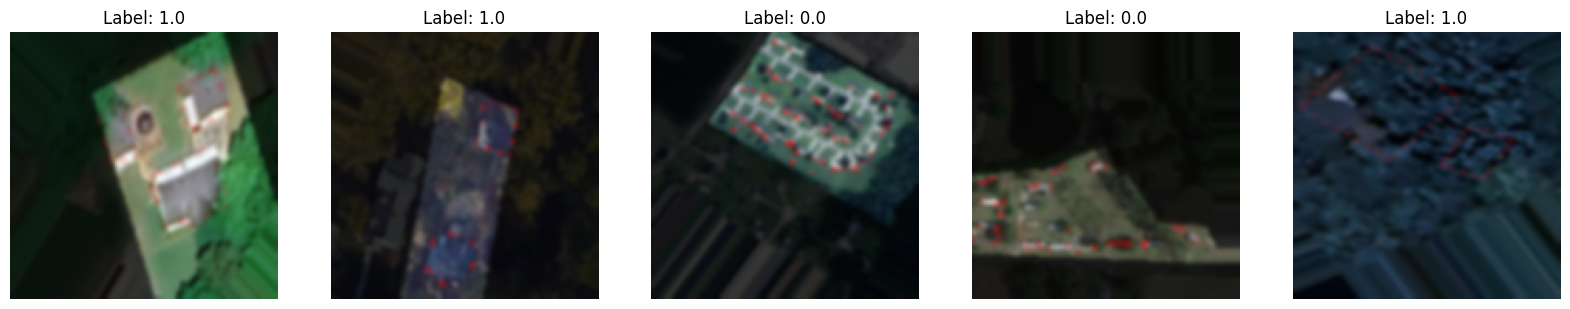

In [91]:
# function to plot images
def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i]
        label = labels[i]
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.show()

# Get a batch of training images and labels
images, labels = next(train_generator)

# Plot the images
plot_images(images, labels)

Now, let us built the model to classify the images.

## **CNN for Image Classification**

We will be using a very basic CNN model.

In [92]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([

    # 1st convolutional layer with 32 filters, has a kernel size of 3*3, using ReLU as the activation function, and last 3 denotes 3 color channel i.eRGB
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),

    # Max pooling layer with a pool size of (2, 2)
    MaxPooling2D((2, 2)),

    # 2nd convolutional layer with 64 filters and kernel size of (3, 3)
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3rd concolution layer with 128 filters and same ernel size as the previous two steps
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten layer to convert 2D matrices into a 1D vector for the fully connected layers
    Flatten(),

    # The fully connected layer with 128 units and ReLU activation function
    Dense(128, activation='relu'),

    # Dropout layer with 0.5 rate, that means it randomly drops 50% of the units to prevent overfitting
    Dropout(0.5),

    # Output layer with 1 unit, using sigmoid activation as it a binary classification
    Dense(1, activation='sigmoid')
])

In [93]:
# Compile the model
model.compile(

    # Using Adam optimizer for training the model
    optimizer='adam',

    # binary cross-entropy as the loss functio as it suitable for binary classification
    loss='binary_crossentropy',

    # using accuracy as a metric to measure performance of model.
    metrics=['accuracy'])


In [94]:
# Train the model

# model will be trained for 10 epochs
epochs = 10

# Fitting the model on the training data and validating on the testing data
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

Epoch 1/10
15/15 [==============================] - 30s 2s/step - loss: 0.7262 - accuracy: 0.4896 - val_loss: 0.6729 - val_accuracy: 0.5000
Epoch 2/10
15/15 [==============================] - 25s 2s/step - loss: 0.6817 - accuracy: 0.5188 - val_loss: 0.6482 - val_accuracy: 0.5500
Epoch 3/10
15/15 [==============================] - 29s 2s/step - loss: 0.6635 - accuracy: 0.6042 - val_loss: 0.6893 - val_accuracy: 0.5333
Epoch 4/10
15/15 [==============================] - 27s 2s/step - loss: 0.6865 - accuracy: 0.5479 - val_loss: 0.6598 - val_accuracy: 0.6667
Epoch 5/10
15/15 [==============================] - 27s 2s/step - loss: 0.6409 - accuracy: 0.6500 - val_loss: 0.6104 - val_accuracy: 0.6833
Epoch 6/10
15/15 [==============================] - 25s 2s/step - loss: 0.6565 - accuracy: 0.6479 - val_loss: 0.6577 - val_accuracy: 0.6167
Epoch 7/10
15/15 [==============================] - 27s 2s/step - loss: 0.6399 - accuracy: 0.6375 - val_loss: 0.6205 - val_accuracy: 0.7167
Epoch 8/10
15/15 [==

Now let us see the model's performance on the validation data to understand how well the it is likely to perform on unseen data

In [95]:
# # Evaluate the model on the validation/testing data
loss, accuracy = model.evaluate(validation_generator)

# printing the accracy
print(f'Validation Accuracy: {accuracy:.4f}')

4/4 [==============================] - 3s 734ms/step - loss: 0.5062 - accuracy: 0.7417
Validation Accuracy: 0.7417


We can see that the accuracy of the model on test dataset is 74.17%

## **Model Evaluation and Report**

Apart from accuracy let us see some other metrics.
The additional metrics provide more insights into the model's performance beyond just accuracy. <br>
There is classification_report which helps to understand how well the model performs for each class in terms of precision, recall, and F1-score.
<br> Then we have the confusion_matrix that shows the number of true positive, true negative, false positive, and false negative predictions, which is useful for detailed error analysis.

In [96]:
# Additional metrics
from sklearn.metrics import classification_report, confusion_matrix

# Reset the validation generator
validation_generator.reset()

# Get predictions
preds = model.predict(validation_generator)
preds = np.round(preds).astype(int)

# True labels
true_labels = validation_generator.classes

4/4 [==============================] - 5s 1s/step


In [97]:
# Classification report
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.50      0.55      0.52        60
           1       0.50      0.45      0.47        60

    accuracy                           0.50       120
   macro avg       0.50      0.50      0.50       120
weighted avg       0.50      0.50      0.50       120



**Precision:** The proportion of true positive predictions among all positive predictions. <br>
- **For class 0:** 0.50 (50% of predicted class 0 instances are correct)<br>
- **For class 1:** 0.50 (50% of predicted class 1 instances are correct)<br><br>

**Recall:** The proportion of true positive predictions among all actual positive instances.<br>
- **For class 0:** 0.55 (55% of actual class 0 instances are correctly predicted)<br>
- **For class 1:** 0.45 (45% of actual class 1 instances are correctly predicted)





**Summary:**
The model has equal precision, recall, and F1-scores for both classes, indicating it predicts each class equally well (or poorly).
The overall accuracy is 50%, meaning the model's predictions are correct half of the time.
The scores suggest the model is not distinguishing well between the two classes and has room for improvement.



Now let us plot the confusio matrix to see clearly

In [98]:
# Confusion matrix
cm = confusion_matrix(true_labels, preds)
print(cm)

[[33 27]
 [33 27]]


The classification matrix means: <br>
**True Negative (TN):** 33 <br>
- The model correctly predicted 33 instances as class 0 (negative class). <br>

**False Positive (FP):** 27 <br>
- The model incorrectly predicted 27 instances as class 1 (positive class) when they were actually class 0. <br>

**False Negative (FN):** 33 <br>
- The model incorrectly predicted 33 instances as class 0 (negative class) when they were actually class 1. <br>

**True Positive (TP):** 27 <br>
- The model correctly predicted 27 instances as class 1 (positive class).


**Summary:** <br>
* The model correctly identified 33 negative instances and 27 positive instances.
* The model misclassified 27 negative instances as positive and 33 positive instances as negative.
* This confusion matrix reflects a balance between correctly and incorrectly classified instances, indicating that the model struggles equally with both classes.

**Insights:** <br>
- High Misclassification: The model has a significant number of both false positives and false negatives, indicating it struggles to correctly classify both classes.
- Balanced Errors: The number of false positives and false negatives is equal, suggesting no particular bias towards one class over the other.

Now, let us plot the model accuracy for both training and testing data

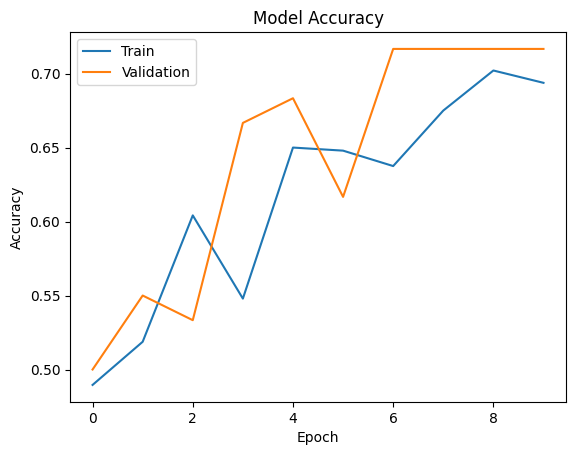

In [99]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


- The blue line represents the training accuracy of a machine learning model. It starts around 0.50 and gradually increases with each epoch (training iteration). This indicates that the model is learning from the training data.
- The orange line represents the validation accuracy, which measures how well the model generalizes to unseen data. Initially, it follows the training accuracy but diverges after epoch 3
- The x-axis shows the number of training epochs. The model improves up to epoch 6, but validation accuracy plateaus or decreases afterward.

Also, let us plot the model loss for both train and validation data

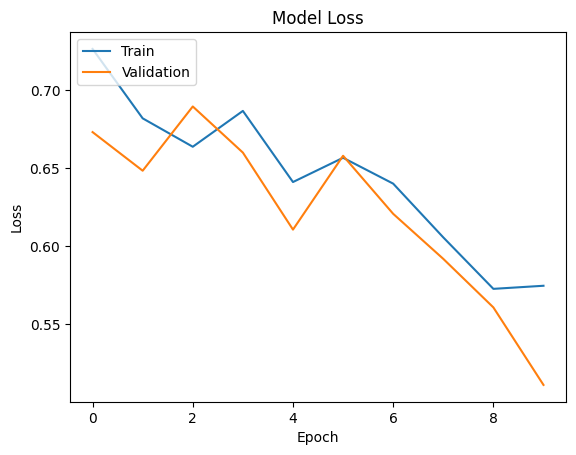

In [100]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- The blue line represents the training loss of a machine learning model. It starts around 0.70 and gradually decreases with each epoch (training iteration). Lower loss indicates better performance on the training data.
- The orange line represents the validation loss, which measures how well the model generalizes to unseen data. It also decreases overall but exhibits fluctuations. These fluctuations suggest that the model may not perform consistently well on new data.
- The x-axis shows the number of training epochs. The model improves up to epoch 6, but validation loss fluctuates after that.<br>
In summary, the model is learning from the training data, but its performance on unseen data varies

## **Suggestions for improvement**

To improve the model's accuracy and reduce misclassifications, we can do some of the following steps:
- **Data Augmentation:** We can apply more sophisticated augmentation techniques to increase the diversity of the training data. For example, without any data augmentation we got an accuracy of 65% by taking image size of 224 *224.
Similarly by converting image to grayscale and using 128*128 image size we got an accuracy of 68.33. The confusion matrix was
[[ 25 35 ]<br> [ 36 24 ]].
<br> so we can experiment more with that.
- **Model Architecture:** We can experiment with more deeper or more complex architectures. For example, when we try adding more layers in the cnn model and see.
- **Hyperparameter Tuning:** We can adjust the learning rates, batch sizes, and other hyperparameters to get the best accuracy.
- **Regularization:** We can add some regularization to reduce overfitting. we tried with L2 regularization and got an accuracy of 50% so did not use that.
- **Add more Training Data** - Since we are using deep learning, having more data helps the model to learn much better compared to less training data